# Meta-RL Predictability Study: Stock-Month Advantage Classifier

## Objective

Identify and classify stock-month environments where a reinforcement learning (RL) agent (PPO) outperforms a random strategy. These environments are considered "predictable" or advantageous for training trading agents.

---

## Dataset

* **Source:** Cleaned OHLCV data (daily resolution)
* **Date range:** 2022-01-01 to 2023-01-01
* **Universe:** Top US equities (e.g., AAPL, MSFT, JPM, AMZN, TSLA, etc.)
* **Exclusions:** Tickers with missing or corrupted data

---

##  Meta-Feature Engineering

For each stock-month pair (symbol, month):

1. **Return Distribution** from month *t*:

   * Mean Return
   * Std Return
   * Skewness
   * Kurtosis
   * Shannon Entropy (10-bin histogram)

2. **Volume Features**:

   * Mean Volume
   * Std Volume

3. **Residual Diagnostics (month t+1)**:

   * Fit `RandomForestRegressor` on lagged returns (lags=5)
   * Compute residuals: `actual - predicted`
   * Ljung-Box p-value (autocorrelation)
   * Residual ACF(1)
   * Residual Std, Skew, Kurtosis

4. **Rolling R² (CV)**

   * Use 3-fold cross-validation on the same model
   * Target: `cv_r2` as a proxy for local predictability

---

## Meta-RL Labeling Pipeline

1. **Custom Gym Environment**: `CumulativeTradingEnv`
2. **Per stock-month**:

   * Train PPO agent (stable-baselines3)
   * Evaluate cumulative reward
   * Compare against baseline (random policy)
   * Compute:

     * `agent_reward`, `random_reward`
     * `advantage = agent_reward - random_reward`
     * Other metrics: `sharpe`, `alpha`, `cumulative_return`
3. **Label Definition**:

   * Binary target: `1` if advantage > 0 else `0`

---

## Final Feature Set

```
['mean_return', 'std_return', 'skew', 'kurtosis', 'entropy',
 'vol_mean', 'vol_std',
 'ljung_pval', 'resid_acf1', 'resid_std', 'resid_skew', 'resid_kurtosis',
 'sharpe', 'cum_return', 'alpha']
```

---

## Classifier Results

**Model**: `RandomForestClassifier(n_estimators=200, class_weight="balanced")`

**Train/Test Split**: 80/20 (Stratified)

### Classification Report:

```
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       420
           1       0.97      0.89      0.93       675

    accuracy                           0.91      1095
   macro avg       0.91      0.92      0.91      1095
weighted avg       0.92      0.91      0.91      1095
```

### Confusion Matrix:

```
[[400  20]
 [ 74 601]]
```

---

## Interpretation

* High overall accuracy (91%) and balanced class performance
* The model is especially good at predicting when RL **will** work (class 1)
* A powerful tool for **pre-filtering environments** before launching full RL training

---

## Next Steps

* ✅ Feature importance (SHAP, permutation)
* ✅ Add volatility-based meta-features (GARCH, Hurst exponent)
* ✅ Try ranking models: `A > B` if `adv_A > adv_B`
* ✅ Out-of-time validation on 2023+ data
* ✅ Use this model to control which environments enter RL portfolios

---

## Files

* `features_<EXPERIENCE_NAME>.pkl`: Engineered features
* `targets_<EXPERIENCE_NAME>.pkl`: CV R² scores
* `meta_rl_labels_<EXPERIENCE_NAME>.pkl`: Advantage labeling

---

## Requirements

* `scikit-learn`
* `statsmodels`
* `stable-baselines3`
* `gymnasium`
* `pandas`, `numpy`, `joblib`

---

## Authors

* Filipe Mota de Sá @ github.io/pihh
* ChatGPT (OpenAI)

---

*"Not all environments are created equal. Filter wisely."*


In [1]:
# SETUP: Imports & Paths ===========================
import jupyter
from src.utils.system import boot, Notify

boot()
import os
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm

from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display

from src.experiments.experiment_tracker import ExperimentTracker
from src.config import TOP2_STOCK_BY_SECTOR
from src.defaults import default_central_tendecy_measure

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, acovf
from src.env.base_timeseries_trading_env import SequenceAwareAlphaTradingEnv,SequenceAwareNormAbsMoveEnv

import warnings
warnings.filterwarnings("ignore")


C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [47]:
    config=dict(start_date="2024-06-01",end_date="2025-01-01")
    ohlcv_df = load_base_dataframe()
    ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
    ohlcv_df = ohlcv_df[(ohlcv_df['date'] >= config["start_date"]) & (ohlcv_df['date'] < config["end_date"])]
    ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
    ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)
    ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
    ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')

In [ ]:
import random
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces


from src.env.step_rewards import reward_sharpe,reward_sortino,reward_drawdown,reward_alpha,reward_cumulative,reward_calmar,reward_hybrid

class BaseSequenceAwareTradingEnv(gym.Env):
    """
    Flexible RL Trading Env with windowed sequence obs (Transformer/LSTM/MLP-ready).
    - Set `return_sequences=True` for (window_length, obs_dim) obs (for transformers).
    - Set `return_sequences=False` for flat obs (classic RL, SB3 LSTM/MLP).
    """
    metadata = {"render_modes": ["human"]}

    def __init__(
        self, df, feature_cols=None, reward_fn=None, internal_features=None,
        episode_length=100, transaction_cost=0.0001, seed=314, window_length=10, return_sequences=True):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or []
        self.internal_features = internal_features or [
            "position", "holding_period", "cumulative_reward", "pct_time",
            "drawdown", "rel_perf", "unrealized_pnl", "entry_price", "time_in_position"
        ]
        self.obs_dim = len(self.feature_cols) + len(self.internal_features)
        self.episode_length = episode_length +2
        self.window_length = max(1, window_length)
        self.return_sequences = return_sequences  # True: (window, obs_dim), False: flat
        self.transaction_cost = transaction_cost
        self.seed = seed
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if seed is not None:
            np.random.seed(seed)
        counts = df['symbol'].value_counts()
        eligible = counts[counts >= episode_length].index
        self.stocks = df[df['symbol'].isin(eligible)]['symbol'].unique()
        self.episode_df = df.copy()
        self.reward_fn = reward_fn or self.default_reward_fn

        # Set observation space
        if self.return_sequences:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length, self.obs_dim), dtype=np.float32
            )
        else:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length * self.obs_dim,), dtype=np.float32
            )
        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell

    
    def get_current_regime(self):
        """
        Detects current regime based on recent return volatility and trend.
        Returns:
            0 = Bull, 1 = Bear, 2 = Sideways
        """
        if self.current_step < self.window_length:
            return 2  # Not enough data, assume sideways

        # Use recent price changes to detect regime
        returns = self.episode_df['return_1d'].iloc[self.current_step - self.window_length:self.current_step].values
        mean_return = returns.mean()
        std_return = returns.std()

        # Thresholds can be tuned
        if mean_return > 0.001 and std_return < 0.01:
            return 0  # Bull
        elif mean_return < -0.001 and std_return < 0.01:
            return 1  # Bear
        else:
            return 2  # Sideways
        
    def default_reward_fn(self, position, price_change, **kwargs):
        return position * price_change

    def set_episode_sequence(self, sequence):
        self.episode_sequence = sequence
        self.episode_counter = 0

    def generate_episode_sequences_v1(self, train_steps=10000):
        dataset_length = len(self.df)
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        ticker = self.df['symbol'].unique()[0]
        min_start = 0
        max_start = dataset_length - self.episode_length - 2
        for i in range(episodes):
            episode_sequences.append((ticker, np.random.randint(0, max_start)))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def generate_episode_sequences(self, train_steps=10000):
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        for _ in range(episodes):
            ticker = np.random.choice(self.stocks)
            stock_df = self.df[self.df['symbol'] == ticker].reset_index(drop=True)
            max_start = len(stock_df) - self.episode_length - 2
            if max_start <= 0:
                continue  # skip if not enough data
            start = np.random.randint(0, max_start)
            episode_sequences.append((ticker, start))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def reset(self, seed=None, options=None, start_index=None):
        self.entry_step = None
        self.unrealized_pnl = 0
        self.relative_perf = 0
        self.drawdown = 0
        self.time_in_position = 0
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if self.seed is not None:
            np.random.seed(self.seed)
            
            
        symbol, start_idx = self.episode_sequence[self.episode_counter]
        #print(symbol,start_idx,self.df['symbol'].unique())
        symbol_df = self.df[self.df['symbol'] == symbol].reset_index(drop=True)
        #print(len(symbol_df))
        
        if start_idx + self.episode_length > len(symbol_df):
            print(f"[WARN] Episode too short for {symbol} at {start_idx}, skipping...")
            self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
            return self.reset()  # tenta o próximo episódio

        # ✅ Extração segura
        #self.episode_df = symbol_df.iloc[start_idx : start_idx + self.episode_length].copy()
        end = start_idx + self.episode_length + 1
        if end > len(symbol_df):
            print(f"[WARN] Not enough data for {symbol} from {start_idx}, skipping.")
            self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
            return self.reset()
        self.episode_df = symbol_df.iloc[start_idx:end].copy()
        

        # Move to next episode (with wrap-around)
        self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
        """
        for _ in range(10):  # Try up to 10 times to get a valid episode
            stock = self.stocks[0]
            if hasattr(self, "episode_sequence"):
                if self.episode_counter >= len(self.episode_sequence):
                    self.episode_counter = 0
                _, start = self.episode_sequence[self.episode_counter]
                self.episode_counter += 1
            else:
                stock = np.random.choice(self.stocks)
                stock_df = self.df[self.df['symbol'] == stock].reset_index(drop=True)
                max_start = len(stock_df) - self.episode_length
                if max_start <= 0:
                    continue  # Try another stock
                start = np.random.randint(0, max_start + 1)

            self.stock = stock
            stock_df = self.df[self.df['symbol'] == self.stock].reset_index(drop=True)
            self.episode_df = stock_df.iloc[int(start):int(start) + int(self.episode_length + 2)].reset_index(drop=True)

            if len(self.episode_df) >= self.window_length:
                break
        else:
            raise RuntimeError("Failed to sample a valid episode with sufficient data.")
        """
        self.current_step = 0
        self.entry_price = None
        self.position = 0
        self.holding_period = 0
        self.cumulative_reward = 0
        self.returns_history = []
        self.reward_history = []
        self.episode_pct_changes = self.episode_df['return_1d'].values
        self.max_possible_reward = np.sum(np.abs(self.episode_pct_changes))
        self.current_wealth = 1.0
        self.peak_wealth = 1.0

        return self._get_obs(), {}

    def _get_obs(self):
        # Returns a rolling window of observations (2D or flattened)
        obs_list = []
        #for i in range(self.current_step - self.window_length + 1, self.current_step + 1):
        #    idx = max(i, 0)  # pad with earliest available step
        #    features = self.episode_df.iloc[idx][self.feature_cols].values.astype(np.float32)
        for i in range(self.current_step - self.window_length + 1, self.current_step + 1):
            if 0 <= i < len(self.episode_df):
                features = self.episode_df.iloc[i][self.feature_cols].values.astype(np.float32)
            else:
                features = np.zeros(len(self.feature_cols), dtype=np.float32)  # zero padding
            internal_state = {
                "position": self.position,
                "holding_period": self.holding_period,
                "cumulative_reward": self.cumulative_reward,
                "pct_time": self.current_step / self.episode_length,
                "drawdown": self.drawdown,
                "rel_perf": self.relative_perf,
                "unrealized_pnl": self.unrealized_pnl,
                "entry_price": self.entry_price if self.entry_price is not None else 0.0,
                "time_in_position": self.time_in_position,
            }
            internal = np.array([internal_state[name] for name in self.internal_features], dtype=np.float32)
            obs = np.concatenate([features, internal])
            obs_list.append(obs)
        obs_window = np.stack(obs_list)  # shape: (window_length, obs_dim)
        if self.return_sequences:
            return obs_window  # shape: (window_length, obs_dim)
        else:
            return obs_window.flatten()  # shape: (window_length * obs_dim,)
        
    

    def step(self, action):
        #print(self.current_step,self.episode_length,len(self.episode_df))
        done = self.current_step >= self.episode_length - 1
        current_row = self.episode_df.iloc[self.current_step]

        # Protege contra acesso fora dos limites
        if self.current_step + 1 < len(self.episode_df):
            next_row = self.episode_df.iloc[self.current_step + 1]
        else:
            next_row = current_row.copy()  # fallback seguro

        price_change = next_row['return_1d']
        prev_position = self.position
        reward = 0
        cost = 0

        self.action_counts[action] += 1

        if action == 1:  # Buy
            if self.position != 1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = 1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step

        elif action == 2:  # Sell
            if self.position != -1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = -1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step

        if self.position != 0:
            self.holding_period += 1

        step_return = self.position * price_change
        self.returns_history.append(step_return)
        self.current_wealth *= (1 + step_return)
        if self.current_wealth > self.peak_wealth:
            self.peak_wealth = self.current_wealth
        self.drawdown = 1 - self.current_wealth / self.peak_wealth

        if self.position != 0 and self.entry_price is not None:
            current_price = next_row['close']
            self.unrealized_pnl = (current_price - self.entry_price) * self.position / self.entry_price
            self.time_in_position = self.current_step - self.entry_step
        else:
            self.unrealized_pnl = 0
            self.time_in_position = 0

        if 'market_return_1d' in self.episode_df.columns:
            self.relative_perf = price_change - next_row['market_return_1d']
        else:
            self.relative_perf = 0

        reward = self.reward_fn(
            position=self.position,
            price_change=price_change,
            prev_position=prev_position,
            env=self
        )
        reward -= cost
        self.reward_history.append(reward)
        self.cumulative_reward += reward

        self.current_step += 1
        obs = self._get_obs()
        info = {}
        info["regime"] = self.get_current_regime()

        # Calcula métricas no final do episódio
        if done:
            returns = np.array(self.returns_history)
            mean = np.median(returns) if len(returns) > 0 else np.nan
            std = returns.std() if len(returns) > 1 else np.nan
            downside = returns[returns < 0]
            downside_std = downside.std() if len(downside) > 1 else np.nan

            sharpe = mean / std if (std is not None and std > 0 and not np.isnan(std)) else np.nan
            sortino = mean / downside_std if (downside_std is not None and downside_std > 0 and not np.isnan(downside_std)) else np.nan

            wealth_curve = np.cumprod(1 + returns) if len(returns) > 0 else np.array([])
            peak_wealth = np.maximum.accumulate(wealth_curve) if len(wealth_curve) > 0 else np.array([])
            drawdowns = (wealth_curve - peak_wealth) / (peak_wealth + 1e-8) if len(wealth_curve) > 0 else np.array([])
            max_drawdown = np.abs(drawdowns.min()) if len(drawdowns) > 0 else np.nan
            calmar = ((wealth_curve[-1] - 1) / max_drawdown) if (len(wealth_curve) > 0 and max_drawdown and not np.isnan(max_drawdown) and max_drawdown > 0) else np.nan
            cum_return = wealth_curve[-1] - 1 if len(wealth_curve) > 0 else np.nan
            final_wealth = wealth_curve[-1] if len(wealth_curve) > 0 else np.nan

            # Trade-level metrics
            trades = []
            trade_profits = []
            prev = 0
            for i, ret in enumerate(returns):
                if prev == 0 and ret != 0:
                    entry_idx = i
                    entry_dir = np.sign(ret)
                elif prev != 0 and (ret == 0 or np.sign(ret) != np.sign(prev)):
                    if 'entry_idx' in locals():
                        trade = returns[entry_idx:i+1]
                        trade_profits.append(np.sum(trade))
                        del entry_idx
                prev = ret
            win_rate = np.median(np.array(trade_profits) > 0) if trade_profits else np.nan

            if 'market_return_1d' in self.episode_df.columns:
                market_returns = self.episode_df['market_return_1d'].values[1:self.episode_length]
                market_wealth_curve = np.cumprod(1 + market_returns) if len(market_returns) > 0 else np.array([])
                market_cum_return = market_wealth_curve[-1] - 1 if len(market_wealth_curve) > 0 else np.nan
                alpha = cum_return - market_cum_return if cum_return is not None and not np.isnan(cum_return) and market_cum_return is not None and not np.isnan(market_cum_return) else np.nan
            else:
                alpha = np.nan

            info.update({
                "episode_sharpe": sharpe,
                "episode_sortino": sortino,
                "episode_total_reward": np.sum(self.reward_history) if len(self.reward_history) > 0 else np.nan,
                "cumulative_return": cum_return,
                "calmar": calmar,
                "max_drawdown": max_drawdown,
                "win_rate": win_rate,
                "alpha": alpha,
                "returns": returns,
                "market_returns": market_returns if 'market_returns' in locals() else [],
                "downside": downside,
                "regime": self.get_current_regime(),
                "final_wealth": final_wealth,
                "action_hold_count": self.action_counts[0],
                "action_buy_count": self.action_counts[1],
                "action_sell_count": self.action_counts[2]
            })

        return obs, reward, done, False, info

    def render(self):
        print(f"Step: {self.current_step} | Pos: {self.position} | Hold: {self.holding_period} | CumRew: {self.cumulative_reward:.4f}")



class SequenceAwareSharpeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sharpe, **kwargs)

class SequenceAwareSortinoTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sortino, **kwargs)

class SequenceAwareAlphaTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_alpha, **kwargs)

class SequenceAwareDrawdownTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_drawdown, **kwargs)

class SequenceAwareCumulativeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_cumulative, **kwargs)

class SequenceAwareCalmarTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_calmar, **kwargs)

class SequenceAwareHybridTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_hybrid, **kwargs)

class SequenceAwareBaselineTradingAgent:
    def __init__(self,df,feature_cols=[],
            episode_length=100, seed=314,set_episode_sequence=[]):
    
        self.env = BaseSequenceAwareTradingEnv(df, feature_cols=feature_cols,
            episode_length=episode_length, seed=seed)
        self.env.set_episode_sequence(set_episode_sequence)
        
    def predict(self,obs,*args,**kwargs):
        #print(self.env.stocks,'xxxxxxxxxxx')
        return self.env.action_space.sample(),{}
    
    def set_episode_sequence(self,seq):
        
        pass

    
    
# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # should return 0, 1, or 2
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)
    
    
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
EPISODE_LENGTH = 100
MAX_LENGTH = 200
SAVE_FREQ=10000
EVAL_FREQ=5000
TOTAL_TIMESTEPS=1_200_000
#TOTAL_TIMESTEPS=1000
EPISODES_PER_UPDATE = 8          # ~how many episodes before PPO updates
EPISODES_PER_BATCH = 1           # number of full episodes per batch

# === Auto-derive PPO settings ===
N_STEPS = EPISODE_LENGTH * EPISODES_PER_UPDATE
BATCH_SIZE = EPISODE_LENGTH * EPISODES_PER_BATCH
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
# Causal Mask Function ============================
def generate_causal_mask(seq_len):
    return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)

# Transformer Feature Extractor ===================
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, n_heads=4, n_layers=2, max_len=MAX_LENGTH):
        super().__init__(observation_space, features_dim=d_model)
        self.d_model = d_model
        input_dim = observation_space.shape[-1]

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward_v1(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]
        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)
        return x[:, -1]  # return the last token output
    
    def forward(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        #print(">>> [Transformer] Input shape:", obs.shape)

        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]

        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)

        pooled_output = x[:, -1]
        #print(">>> [Transformer] Pooled output mean/std:", pooled_output.mean().item(), pooled_output.std().item())

        return pooled_output

# Transformer Policy ===================================
class TransformerPolicy(RecurrentActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs,
                         features_extractor_class=TransformerFeatureExtractor,
                         features_extractor_kwargs=dict(
                             d_model=64, n_heads=4, n_layers=2, max_len=32
                         ))
        #self._build(self.lr_schedule)

# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # 0,1,2 -> bull,bear,sideways
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

class PerEpisodeRewardNormalizer(gym.Wrapper):
    def reset(self, **kwargs):
        self.episode_rewards = []
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_rewards.append(reward)
        mean = np.mean(self.episode_rewards)
        std = np.std(self.episode_rewards) + 1e-8
        norm_reward = (reward - mean) / std
        return obs, norm_reward, done, truncated, info
# Training =============================================================

"""
train_df = ohlcv_df[(ohlcv_df['date']>="2023-01-01") & (ohlcv_df['date']<"2023-07-01")]
test_df = ohlcv_df[(ohlcv_df['date']>="2023-07-01") & (ohlcv_df['date']<"2024-01-01")]
train_df = train_df[train_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]

train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
test_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
# Train on few episodes to prove a point only
train_seq = train_env.generate_episode_sequences(TOTAL_TIMESTEPS)
_test_seq = test_env.generate_episode_sequences(int(TOTAL_TIMESTEPS))
episodes = _test_seq
unique_episodes = {}
for ticker, start in episodes:
    if ticker not in unique_episodes:
        unique_episodes[ticker] = start
# Convert back to a list of tuples
test_seq = [(ticker, start) for ticker, start in unique_episodes.items()]

print(f"Training on {len(train_seq)} different episodes accross the top 2 stocks for each sector")
print(f"Testing on {len(test_seq)} different episodes accross the top 2 stocks for each sector")
def train_agent():
    
    
    
    train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    train_env.set_episode_sequence(train_seq)
    eval_env.set_episode_sequence(test_seq)
    
    train_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(train_env))
    eval_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env))
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ, save_path=checkpoint_path, name_prefix=checkpoint_preffix
    )

    eval_callback = EvalCallback(
        eval_env, best_model_save_path=checkpoint_best_model,
        log_path=log_path, eval_freq=EVAL_FREQ, deterministic=True
    )

    model = RecurrentPPO(
        policy=TransformerPolicy,
        env=train_env,
        verbose=1,
        #tensorboard_log="./tensorboard_logs",
        n_steps=N_STEPS,
        batch_size=BATCH_SIZE,
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.005,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        policy_kwargs=dict(share_features_extractor=True)
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback, eval_callback])
    model.save(save_path)

if __name__ == "__main__":
    train_agent()
"""
print('x')

In [53]:
class MarketVersusWalletHistoryTracker:
    def __init__(self, initial_wallet=1.0):
        self.wallet_value = initial_wallet
        self.prev_wallet_value = initial_wallet
        self.wallet_locked = False
        self.buy_price = None
        self.market_entry_price = None
        self.last_price = None
        self.has_opened_position = False  # NEW: ensure proper update after first buy

        self.wallet_history = []
        self.market_history = []
        self.price_history = []
        self.action_history = []

    def reset(self, initial_price):
        self.__init__(initial_wallet=1.0)
        self.market_entry_price = initial_price
        self.last_price = initial_price
        self.wallet_history.append(self.wallet_value)
        self.market_history.append(1.0)
        self.price_history.append(initial_price)
        self.action_history.append(0)

    def step(self, action, current_price):
        self.price_history.append(current_price)
        agent_action = 0

        # === 1. Update market benchmark ===
        market_perf = current_price / self.market_entry_price
        self.market_history.append(market_perf)

        # === 2. Update wallet value ===
        if self.wallet_locked and self.has_opened_position:
            self.wallet_value *= current_price / self.last_price

        self.wallet_history.append(self.wallet_value)
        self.prev_wallet_value = self.wallet_value
        self.last_price = current_price  # must be set after wallet update!

        # === 3. Process Action ===
        if action == 1 and not self.wallet_locked:
            self.buy_price = current_price
            self.wallet_locked = True
            self.has_opened_position = True
            agent_action = 1

        elif action == 2 and self.wallet_locked:
            self.wallet_locked = False
            self.buy_price = None
            self.has_opened_position = False
            agent_action = 2

        self.action_history.append(agent_action)

    def export(self):
        return {
            "wallet_history": self.wallet_history,
            "market_history": self.market_history,
            "market_price_history": self.price_history,
            "performed_action_history": self.action_history
        }


In [89]:
mrl = pd.read_csv('mrl.csv').dropna().sort_values(by="advantage")
mrl[mrl['month']=="2024-07"].sort_values(by="advantage")
#mrl['month']

,Unnamed: 0,symbol,month,agent_reward,random_reward,advantage,sharpe,cum_return,alpha
55,55,LLY,2024-07,0.000000,0.046895,-0.046895,0.039106,0.042680,0.049739
97,97,TSLA,2024-07,0.000000,0.035089,-0.035089,-0.064102,0.009296,0.016356
25,25,CVX,2024-07,-0.020704,-0.001159,-0.019545,0.005291,-0.002565,0.004494
127,127,XOM,2024-07,-0.029142,-0.011747,-0.017396,-0.468836,-0.013258,-0.006199
1,1,AAPL,2024-07,0.000000,0.004608,-0.004608,0.024561,0.002551,0.009610
43,43,JPM,2024-07,0.000000,-0.002820,0.002820,-0.020795,-0.004753,0.002306
13,13,AMZN,2024-07,0.079762,0.065906,0.013855,0.236207,0.065973,0.073033
85,85,SHW,2024-07,0.000000,-0.022477,0.022477,-0.079437,-0.027079,-0.020020
115,115,V,2024-07,0.000000,-0.023880,0.023880,-0.162587,-0.025522,-0.018462
37,37,GOOGL,2024-07,0.000000,-0.035126,0.035126,0.022262,-0.037938,-0.030879


2024-07-01 04:00:00 2024-07-01 04:00:00 True
2024-07-01 04:00:00 2024-07-01 04:00:00 True


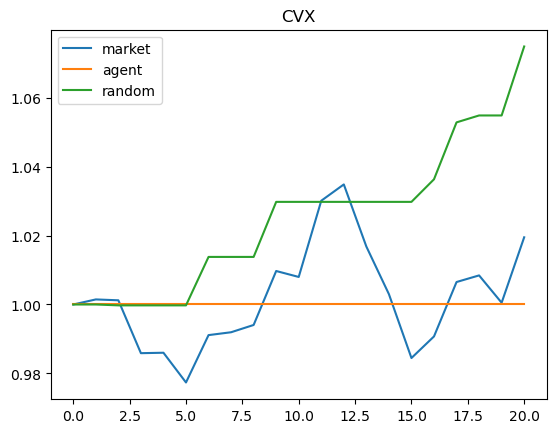

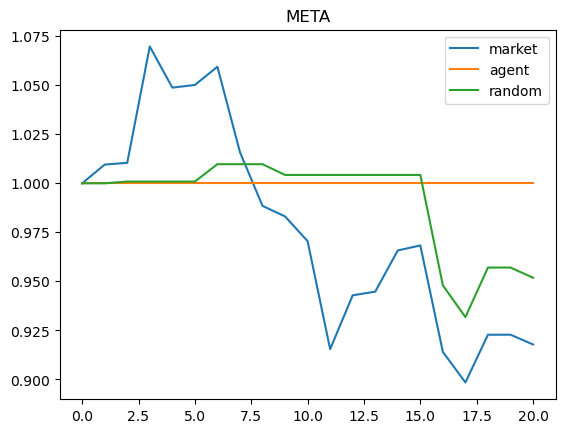

In [98]:
#mrl = pd.read_csv('mrl.csv').dropna().sort_values(by="advantage")
from src.env.base_trading_env import AlphaTradingEnv

#UNH	UNH	2024-08
#WMT	2024-08
feature_cols = ['return_1d','volume']
episode_length=21
seed =314
train_steps=1000
test_df = ohlcv_df[ohlcv_df['symbol'].isin(["CVX","META"])]
test_df = test_df[(test_df['date']>="2024-07-01") & (test_df['date']<"2024-08-01")]
for s in ['CVX','META']:
    df_env = test_df[test_df['symbol'] == s].sort_values("date")
    
    env = AlphaTradingEnv(
                df=df_env,
                feature_cols=feature_cols,
                episode_length=episode_length,
                transaction_cost=0,
                seed=seed
            )
    env = gym.wrappers.FlattenObservation(env)
    check_env(env, warn=True)

    model = PPO("MlpPolicy", env, verbose=0, n_steps=64, batch_size=16, learning_rate=0.001, seed=seed)
    model.learn(total_timesteps=train_steps)

    # Evaluate PPO
    obs, _ = env.reset()
    agent_rewards, done = [], False
    initial_price = env.env.episode_df.iloc[0]['close']
    agent_tracker = MarketVersusWalletHistoryTracker()
    agent_tracker.reset(initial_price)
    agent_episode_start = env.env.episode_df.iloc[0].timestamp
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        agent_rewards.append(reward)
        current_price = env.env.episode_df.iloc[env.env.current_step]['close']

        # Step the wallet tracker
        agent_tracker.step(action, current_price)
    agent_reward = np.sum(agent_rewards)
    
    # Evaluate Random
    obs, _ = env.reset()
    random_rewards, done = [], False
    random_episode_start = env.env.episode_df.iloc[0].timestamp
    initial_price = env.env.episode_df.iloc[0]['close']
    random_tracker = MarketVersusWalletHistoryTracker()
    random_tracker.reset(initial_price)

    while not done:
        action = env.action_space.sample()
  
        obs, reward, done, truncated, info = env.step(action)
        current_price = env.env.episode_df.iloc[env.env.current_step]['close']
        random_rewards.append(reward)
        random_tracker.step(action, current_price)
    random_reward = np.sum(random_rewards)
    print(agent_episode_start,random_episode_start,agent_episode_start==random_episode_start)
    pd.DataFrame({"market":agent_tracker.market_history,"agent":agent_tracker.wallet_history,"random":random_tracker.wallet_history}).plot(title=s)

In [97]:
agent_tracker.action_history

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [94]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import joblib
from src.env.base_trading_env import CumulativeTradingEnv,AlphaTradingEnv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


def load_and_train_rl_agent(
    experience_name,
    ohlcv_df,
    meta_df,
    feature_cols = ["return_1d", "volume"] ,
    episode_length = 21,
    train_steps = 300,
    min_ep_len = 18,
    seed=314,
    env_class=CumulativeTradingEnv
):

    RL_LABELS_PATH =f"../data/cache/meta_rl_labels_{experience_name}.pkl"


    # Resume logic: Load meta_df with RL columns if available
    if os.path.exists(RL_LABELS_PATH):
        print(RL_LABELS_PATH)
        meta_df_rl = pd.read_pickle(RL_LABELS_PATH)
        print("Loaded meta_df with RL columns.")
        return meta_df_rl
    else:
        # Copy original meta_df and initialize RL columns
        meta_df_rl = meta_df.copy()
        meta_df_rl['agent_reward'] = np.nan
        meta_df_rl['random_reward'] = np.nan
        meta_df_rl['advantage'] = np.nan
        meta_df_rl['sharpe'] = np.nan
        meta_df_rl['cum_return'] = np.nan
        meta_df_rl['alpha'] = np.nan
    

    best=-np.inf
    worst=np.inf
    for i, row in tqdm(meta_df_rl.iterrows(), total=len(meta_df_rl), desc="Meta-RL Agent Loop"):
        # Skip if already computed
        if not np.isnan(meta_df_rl.loc[i, 'agent_reward']):
            continue

        symbol, month = row['symbol'], row['month']
        df_env = ohlcv_df[(ohlcv_df['symbol'] == symbol) & (ohlcv_df['month'] == month)].sort_values("date")
        if len(df_env) < min_ep_len:
            min_ep_len = len(df_env)
            print('new min',min_ep_len)
        if len(df_env) < episode_length:
            print(f"#{symbol},{month},{len(df_env)} Not enough data, skip")
            continue  # Not enough data, skip

        try:
            env = env_class(
                df=df_env,
                feature_cols=feature_cols,
                episode_length=episode_length,
                transaction_cost=0,
                seed=seed
            )
            env = gym.wrappers.FlattenObservation(env)
            check_env(env, warn=True)

            model = PPO("MlpPolicy", env, verbose=0, n_steps=64, batch_size=16, learning_rate=0.001, seed=seed)
            model.learn(total_timesteps=train_steps)

            # Evaluate PPO
            obs, _ = env.reset()
            agent_rewards, done = [], False
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, truncated, info = env.step(action)
                agent_rewards.append(reward)
            agent_reward = np.sum(agent_rewards)

            # Evaluate Random
            obs, _ = env.reset()
            random_rewards, done = [], False
            while not done:
                action = env.action_space.sample()
                obs, reward, done, truncated, info = env.step(action)
                random_rewards.append(reward)
            random_reward = np.sum(random_rewards)

            advantage = agent_reward - random_reward

            meta_df_rl.loc[i, 'agent_reward'] = agent_reward
            meta_df_rl.loc[i, 'random_reward'] = random_reward
            meta_df_rl.loc[i, 'advantage'] = advantage
            meta_df_rl.loc[i, 'sharpe'] = info.get("episode_sharpe", np.nan)
            meta_df_rl.loc[i, 'cum_return'] = info.get("cumulative_return", np.nan)
            meta_df_rl.loc[i, 'alpha'] = info.get("alpha", np.nan)
            #print(info)
            if advantage > best:
                best =advantage
                best_models 
            if advantage < worst 
                worst = advantage
                
        except Exception as e:
            print(f"Skipped ({symbol})",e)
        meta_df_rl.to_csv(RL_LABELS_PATH)  
    return meta_df_rl

SyntaxError: expected ':' (2658212096.py, line 106)

In [28]:
def generate_stock_predictability_report(
    tickers=[],
    start_date="2022-01-01",
    end_date="2023-01-01",
    n_estimators=100,
    agent_performance_n_estimators=300,
    random_state=314,
    min_samples=10,
    cv_folds=3,
    lags=5,
    trading_environment=CumulativeTradingEnv,
    trading_agent="",
    feature_cols=["return_1d", "volume"],
    seed=314,
    min_episode_length=18
):
    
    EXPERIENCE_NAME = "stock_universe_predictability_selection__MetaFeatures__MetaRlLabeling"
    
    excluded_tickers=['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV']
    excluded_tickers.sort()
    tickers.sort()
    feature_cols.sort()
    #tickers = TOP2_STOCK_BY_SECTOR

    config={
        "experience_name":EXPERIENCE_NAME,
        "regressor":"RandomForestRegressor",
        "n_estimators": n_estimators,
        "min_samples": min_samples,
        "cv_folds": cv_folds,
        "lags": lags,
        "start_date":start_date,
        "end_date":end_date,
        "default_central_tendecy_measure":"ewm_5",
        "environment":trading_environment.__name__,
        "agent": "PPO_MlpPolicy",
        "tickers": "all" if len(tickers) == 0 else json.dumps(tickers),
        "feature_cols": json.dumps(feature_cols),
        "min_samples":min_samples,
        "min_episode_length":18,
        "agent_performance_n_estimators":agent_performance_n_estimators
        #"feature_cols":["return_1d", "volume"]
    }
    run_settings={
        "excluded_tickers": excluded_tickers,
        "seed":seed,
        "random_state":random_state,
    }

    tracker = ExperimentTracker(EXPERIENCE_NAME)
    tracker.set_hash(config)
   
    FILE_SUFFIX = f"{EXPERIENCE_NAME}__{tracker.run_hash}"
    FEATURES_PATH = f"../data/cache/features_{FILE_SUFFIX}.pkl"
    TARGETS_PATH = f"../data/cache/targets_{FILE_SUFFIX}.pkl"
    META_PATH = f"../data/cache/meta_{FILE_SUFFIX}.pkl"


    # DATA =============================================================
    ohlcv_df = load_base_dataframe()
    ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
    ohlcv_df = ohlcv_df[(ohlcv_df['date'] >= config["start_date"]) & (ohlcv_df['date'] < config["end_date"])]
    ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
    ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)
    ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
    ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')
    
    # META-FEATURE / LABEL-EXTRACTION ==================================
    if len(tickers) == 0:
        tickers = ohlcv_df['symbol'].unique()[:5]
        tickers = tickers[~np.isin(tickers, excluded_tickers)]
    
    def default_central_tendecy_measure(arr):
        return pd.Series(arr).ewm(span=5).mean().iloc[-1]

    # Attempt to load if already exists 
    if all([os.path.exists(path) for path in [FEATURES_PATH, TARGETS_PATH, META_PATH]]):
        features = joblib.load(FEATURES_PATH)
        targets = joblib.load(TARGETS_PATH)
        metadata = joblib.load(META_PATH)
        print("Loaded cached feature/target/meta lists.")

    else:
        features, targets, metadata = [], [], []
        for symbol in tqdm(tickers):
            df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
            months = df['month'].unique()
            for i in range(1, len(months)):
                m_t = months[i-1]
                m_t1 = months[i]
                df_t = df[df['month'] == m_t]
                df_t1 = df[df['month'] == m_t1]
                if len(df_t1) < config["min_samples"]:
                    continue
                r1d = df_t['return_1d'].astype(float).values
                v = df_t['volume'].astype(float).values
                feat = {
                    'symbol': symbol,
                    'month_str': str(m_t),
                    'mean_return': default_central_tendecy_measure(r1d),
                    'std_return': r1d.std(),
                    'skew': skew(r1d),
                    'kurtosis': kurtosis(r1d),
                    'entropy': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
                    'vol_mean': default_central_tendecy_measure(v),
                    'vol_std': v.std()
                }
                # Residual diagnostics from simple RF on t+1
                df_lag = df_t1.copy()
                for lag in range(1, config['lags'] + 1):
                    df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
                df_lag = df_lag.dropna()
                if len(df_lag) < config["min_samples"]:
                    continue
                X = df_lag[[f'return_lag_{i}' for i in range(1, config['lags'] + 1)]].values
                y = df_lag['return_1d'].values
                model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=run_settings['random_state'])
                model.fit(X, y)
                residuals = y - model.predict(X)
                # Meta-diagnostics
                ljung_pval = acorr_ljungbox(residuals, lags=[config['lags']], return_df=True).iloc[0]['lb_pvalue']
                feat['ljung_pval'] = ljung_pval
                feat['resid_acf1'] = pd.Series(residuals).autocorr(lag=1)
                feat['resid_std'] = residuals.std()
                feat['resid_skew'] = skew(residuals)
                feat['resid_kurtosis'] = kurtosis(residuals)
                # Predictability label (cross-val R²)
                cv_r2 = default_central_tendecy_measure(cross_val_score(model, X, y, cv=config["cv_folds"], scoring='r2'))
                features.append(feat)
                targets.append(cv_r2)
                metadata.append((symbol, str(m_t)))
        # Save for future resumes
        joblib.dump(features, FEATURES_PATH)
        joblib.dump(targets, TARGETS_PATH)
        joblib.dump(metadata, META_PATH)
        print("Feature/target/meta lists saved.")

    # DataFrame Construction  ============================
    
    X_df = pd.DataFrame(features)
    y_df = pd.Series(targets, name='cv_r2')
    meta_df = pd.DataFrame(metadata, columns=['symbol', 'month'])
    
    # Scaling & Preparation ==============================

    X = X_df.drop(columns=['symbol', 'month_str'])
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Reinforcement Agent Benchmark Training =============
    
    meta_df_rl = load_and_train_rl_agent(FILE_SUFFIX,ohlcv_df,meta_df,env_class=trading_environment)
    
    meta_df_rl.to_csv('mrl.csv')
    meta_df_rl['target'] = (meta_df_rl['advantage'] > 0).astype(int)
    meta_df_rl
    
    feature_cols = [col for col in meta_df_rl.columns if col not in ['symbol', 'month', 'agent_reward', 'random_reward', 'advantage', 'target']]
    # Make sure columns are compatible for merge
    X_df['month'] = X_df['month_str']
    merged = pd.merge(X_df, meta_df_rl, on=['symbol', 'month'], how='inner')
    feature_cols = [
    col for col in merged.columns
        if col not in ['symbol', 'month', 'month_str', 'agent_reward', 'random_reward', 'advantage', 'target']
    ]

    X = merged[feature_cols]
    y = merged['target']

    # Scale features

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    #ohlcv_df.sort_values(by="date").head().to_csv('ohlcv_to_upload.csv')

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=run_settings["random_state"]
    )

    clf = RandomForestClassifier(n_estimators=config["agent_performance_n_estimators"], random_state=run_settings["random_state"], class_weight='balanced')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


    importances = clf.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances)), importances[sorted_idx])
    plt.xticks(range(len(importances)), [feature_cols[i] for i in sorted_idx], rotation=90)
    plt.title("Meta-Feature Importances for Predicting RL Agent Advantage")
    plt.tight_layout()
    plt.show()
    

    # y_true: true labels, y_pred: predicted labels
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)  # Optional: color map
    plt.title("Confusion Matrix")
    plt.show()


    class_names = ['Will Learn', 'Wont learn']  # Adjust to your problem

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Oranges)
    plt.title("Confusion Matrix")
    plt.show()


In [31]:
generate_stock_predictability_report(tickers=TOP2_STOCK_BY_SECTOR,start_date="2024-06-01",end_date="2025-01-01")

../data/cache/meta_stock_universe_predictability_selection__MetaFeatures__MetaRlLabeling__6293649262173480064.pkl


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def generate_classification_diagnostic_report(y_test, y_pred, feature_cols, importances, class_names=None):
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    n_classes = len(report) - 3  # subtract 'accuracy', 'macro avg', 'weighted avg'
    
    # Basic metrics
    accuracy = report['accuracy']
    macro_f1 = report['macro avg']['f1-score']
    weighted_f1 = report['weighted avg']['f1-score']
    support_0 = report[class_names[0]]['support'] if class_names else report['0']['support']
    support_1 = report[class_names[1]]['support'] if class_names else report['1']['support']

    # Class imbalance check
    balance_text = ""
    if abs(support_0 - support_1) > 0.25 * (support_0 + support_1):
        balance_text = (
            "Warning: The dataset is imbalanced between classes. Results might be biased "
            "and should be interpreted with care, especially for the minority class."
        )

    # Overfitting check (perfect scores)
    overfit_text = ""
    if accuracy > 0.99:
        overfit_text = (
            "Caution: The model accuracy is extremely high (>99%), which may indicate overfitting. "
            "Please validate with a separate holdout set or through cross-validation."
        )

    # Key feature importances
    sorted_idx = np.argsort(importances)[::-1]
    key_features = [feature_cols[i] for i in sorted_idx[:5]]

    # Decision
    if accuracy > 0.95 and min(support_0, support_1) > 10:
        decision = "The model performs very well and its predictions can generally be used with confidence."
    elif accuracy > 0.85:
        decision = "The model has solid predictive power, but some caution is advised. Review class-specific metrics."
    else:
        decision = (
            "The model's accuracy is moderate or low. Results should be used for exploration, "
            "not for critical decisions."
        )
    if overfit_text:
        decision = overfit_text + "\n\n" + decision
    if balance_text:
        decision += "\n\n" + balance_text

    # Human-readable summary
    text_report = f"""
Model Classification Diagnostic Report
======================================

Overall Accuracy: {accuracy:.2f}
Macro F1-Score: {macro_f1:.2f}
Weighted F1-Score: {weighted_f1:.2f}

Class Support: 
  {class_names[0] if class_names else 'Class 0'}: {support_0}
  {class_names[1] if class_names else 'Class 1'}: {support_1}

Confusion Matrix:
{cm}

Key Feature Importances:
  {', '.join(key_features)}

Interpretation:
---------------
{decision}

Class-wise precision/recall/f1:
{classification_report(y_test, y_pred, target_names=class_names)}

"""
    print(text_report)
    return text_report


## Quick Recap
We want to estimate how "predictable" each stock is in a given month, using meta-features of its behavior.

#### Pipeline: 
**Loop: For each (stock, month)**
From Previous Month (t) we will extract features. From the returns in month t, we compute:
* Mean
* Std 
* Skew 
* Kurtosis
* Entropy of returns
* Mean of volumne
* Std of volume

These become the meta-features for that stock-month.

**From Following Month (t+1) we will compute "predictability"**

* With 5 lags of daily returns from month t+1 will try to predict daily returns using a RandomForestRegressor
* Evaluate performance with cross-validated R² (cv_r2)
* Analyze residuals from this model with the Ljung–Box test for autocorrelation ⇒ gives ljung_pval

These become the target labels or diagnostic scores

| Feature                 | Description                                        |
| ----------------------- | -------------------------------------------------- |
| `resid_acf1`            | Autocorrelation of residuals (lag 1)               |
| `resid_std`             | Std of residuals                                   |
| `resid_skew`            | Skewness of residuals                              |
| `resid_kurtosis`        | Kurtosis of residuals                              |
| `resid_ljung_pval`      | p-value of Ljung-Box test for residual autocorr    |
| `return_autocorr_1d`    | Lag-1 autocorrelation of raw 1D returns            |
| `volatility_clustering` | Rolling std autocorrelation (vol clustering proxy) |


In [ ]:
2. Feature engineering:
Add features that measure uncertainty, volatility clustering, or market randomness like:

Hurst exponent

GARCH volatility

Rolling ADF p-values

Change-point detection count

| Stage                 | Description                                                                                             |
| --------------------- | ------------------------------------------------------------------------------------------------------- |
| 🧹 Preprocessing      | Clean stock OHLCV data, compute lagged returns                                                          |
| 📈 Forecast Models    | Run simple regressors on next-month returns                                                             |
| 🔍 Diagnostics        | Extract residual meta-features, R², forecast entropy, etc.                                              |
| 🧠 Labeling           | - Regression: R² as target<br>- Ranking: (A > B)<br>- RL Reward: agent learnability                     |
| 📊 Feature Extraction | Use summary stats + diagnostic/meta features                                                            |
| 🧬 Modeling           | - Regression: Predict R²<br>- Classification: Predict "learnable"<br>- Contrastive: Rank predictability |
| 🏆 Output             | Sorted top-k stock-months or environments where RL thrives                                              |


| Section                             | Purpose                                                                                                                                                                                                          |
| ----------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔧 **Setup & Pipeline Description** | High-level explanation of your RL pipeline, feature engineering, and data sources                                                                                                                                |
| 🧪 **Completed Studies**            | Summary table or list of ablation studies, e.g.:<br>`01 - Reward Function Impact`<br>`02 - Predictability Filters via R²`<br>`03 - Meta-Learnability Scores`                                                     |
| ✅ **Conclusions So Far**            | Bullet points of key findings from each experiment, e.g.:<br>– Simple R² doesn't generalize across time<br>– Residual-based features offer better stability<br>– Meta-RL proxy labels correlate with test Sharpe |
| 🔬 **Ongoing Work**                 | One-liner of what’s running or planned, so future you remembers                                                                                                                                                  |
| 📎 **Notebook Index**               | List of notebooks and what each one covers                                                                                                                                                                       |


In [2]:
# AGENTS
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
MAX_LENGTH = 200
# Causal Mask Function ============================
def generate_causal_mask(seq_len):
    return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)

# Transformer Feature Extractor ===================
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, n_heads=4, n_layers=2, max_len=200):
        super().__init__(observation_space, features_dim=d_model)
        self.d_model = d_model
        input_dim = observation_space.shape[-1]

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward_v1(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]
        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)
        return x[:, -1]  # return the last token output
    
    def forward(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        #print(">>> [Transformer] Input shape:", obs.shape)

        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]

        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)

        pooled_output = x[:, -1]
        #print(">>> [Transformer] Pooled output mean/std:", pooled_output.mean().item(), pooled_output.std().item())

        return pooled_output

# Transformer Policy ===================================
class TransformerPolicy(RecurrentActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs,
                         features_extractor_class=TransformerFeatureExtractor,
                         features_extractor_kwargs=dict(
                             d_model=64, n_heads=4, n_layers=2, max_len=32
                         ))
        #self._build(self.lr_schedule)

# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # 0,1,2 -> bull,bear,sideways
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

class PerEpisodeRewardNormalizer(gym.Wrapper):
    def reset(self, **kwargs):
        self.episode_rewards = []
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_rewards.append(reward)
        mean = np.mean(self.episode_rewards)
        std = np.std(self.episode_rewards) + 1e-8
        norm_reward = (reward - mean) / std
        return obs, norm_reward, done, truncated, info
# Training =============================================
def generate_TransformerRecurrentPpo(train_df,test_df,ENV_CLASS,EPISODE_LENGTH,FEATURE_COLS,TOTAL_TIMESTEPS):
    train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    train_env.set_episode_sequence(train_seq)
    eval_env.set_episode_sequence(test_seq)
    
    train_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(train_env))
    eval_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env))
    

    model = RecurrentPPO(
        policy=TransformerPolicy,
        env=train_env,
        verbose=1,
        #tensorboard_log="./tensorboard_logs",
        n_steps=N_STEPS,
        batch_size=BATCH_SIZE,
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.005,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        policy_kwargs=dict(share_features_extractor=True)
    )
    return model
    #model.learn(total_timesteps=TOTAL_TIMESTEPS)

NameError: name 'MAX_LENGTH' is not defined